## Option B

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn.covariance import EmpiricalCovariance

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import sklearn

In [2]:
for i in range(2):
    print(i)

0
1


### Pre-processing

In [4]:
# Read the CSV file
data = pd.read_csv("gp_data_1986_to_2015.csv")

In [5]:
industries = data.columns[3:]
excess = data[industries]

# Create a df with the excess returns for all 43 industries
excess = excess.sub(data["RF"], axis=0)

# Create a df with the excess returns for all 43 industries and market
excess_mkt = excess.copy()
excess_mkt.insert(loc=0, column='MKT', value=data["Mkt-RF"])

### In-sample analysis

In [6]:
# getting expected returns and sd
avg_excess_return = {}
sd_excess_return = {}

for industry in excess.columns:
    avg_excess_return[industry] = excess[industry].mean()
    sd_excess_return[industry] = excess[industry].mean()

In [7]:
# getting covariance matrix
cov_matrix = excess.cov()

In [8]:
# Assigning values to the expected return vector and the covariance matrix
mu = pd.DataFrame.from_dict(avg_excess_return, orient='index').values
V = cov_matrix.values

In [9]:
# function to get gmv
def gmv(V):
    
    ###########
    # Construct the global minimum variance portfolio using the closed form method
    # Input: V is the estimated covariance matrix
    #        NB: the expected return vector is not needed here!
    # Output: The weights of the global minimum variance portfolio
    ###########

    #GMV
    n = len(V)
    w_g = np.linalg.inv(V) @ np.ones(n)
    w_g /= np.sum(w_g)
    
    return w_g

In [10]:
# function to get tangency portfolio
def tangency(mu, V):
    
    ###########
    # Construct the tangency portfolio using the closed form method
    # Input: mu is Estimated expected vector and V is the estimated covariance matrix
    # Output: The weights of the tangency portfolio
    ###########

    
    #tangency portfolio
    w_t = np.linalg.inv(V) @ mu
    w_t /= np.sum(w_t)

    return w_t

In [11]:
# getting gmv weights
w_g = gmv(V)
gmv_allocation = {}

for industry, w in zip(industries, w_g):
    gmv_allocation[industry] = w

In [12]:
# getting tangency weights
w_t = tangency(mu, V)
tangency_allocation = {}

for industry, w in zip(industries, w_t):
    tangency_allocation[industry] = w

In [13]:
gmv_weights = list(gmv_allocation.values())
tangency_weights = list(tangency_allocation.values())
ewp_weights = [1/43] * 43

excess['GMV'] = excess[industries].dot(gmv_weights)
excess['TAN'] = excess[industries].dot(tangency_weights)
excess['EWP'] = excess[industries].dot(ewp_weights)

excess.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals,GMV,TAN,EWP
0,7.36,1.82,-1.76,-1.42,4.99,1.58,3.35,-1.34,-1.52,4.66,...,3.24,4.05,1.35,5.04,1.92,1.11,-0.65,1.063415,3.477564,1.200465
1,13.45,7.36,11.15,7.18,11.67,10.19,7.75,14.14,10.20,8.80,...,9.45,8.15,10.08,6.50,8.32,6.68,8.74,1.789940,-1.700370,7.169767
2,2.14,7.24,10.29,8.57,10.92,5.05,6.26,4.47,4.97,5.57,...,-1.75,3.58,5.01,2.62,6.81,8.51,5.82,0.212038,7.686326,5.365116
3,4.72,-1.09,3.92,-3.44,3.12,3.39,7.84,-1.66,-2.18,-3.30,...,2.17,-3.02,-1.45,-3.16,1.18,-1.22,3.34,-0.730550,4.083248,-0.634419
4,0.59,8.06,7.46,5.88,9.67,2.67,5.42,10.47,4.12,9.29,...,2.02,6.17,4.58,0.21,5.03,11.46,4.40,4.567877,12.992684,4.088140


In [14]:
full_excess = pd.concat([data['Mkt-RF'], excess], axis = 1)
cov_matrix_with_mkt = full_excess.cov()

er = {}
std_dev = {}
sharpe_ratio = {}
beta = {}

for industry in full_excess.columns:
    er[industry] = full_excess[industry].mean()
    std_dev[industry] = full_excess[industry].std()
    sharpe_ratio[industry] = er[industry]/std_dev[industry]
    beta[industry] = cov_matrix_with_mkt['Mkt-RF'][industry] / cov_matrix_with_mkt['Mkt-RF']['Mkt-RF']


In [15]:
# putting in a table
performance_table = pd.DataFrame.from_dict([er, std_dev, sharpe_ratio, beta]).set_axis(['Expected Return', 'Standard Deviation', 'Sharpe Ratio', 'Beta'])
performance_table

,Mkt-RF,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals,GMV,TAN,EWP
Expected Return,0.636361,0.700861,0.836806,0.899500,0.991889,1.254278,0.531028,0.940722,0.480139,0.667972,...,0.751917,0.662083,0.794000,0.674611,0.558750,0.832667,0.789917,0.562142,1.916838,0.718348
Standard Deviation,4.484527,6.400108,4.452608,7.002115,5.107061,6.847884,6.706478,7.596395,5.725771,4.499215,...,6.877761,5.425783,6.110189,5.348291,4.876246,5.370158,5.077974,2.864132,5.288868,4.656860
Sharpe Ratio,0.141902,0.109508,0.187936,0.128461,0.194219,0.183163,0.079181,0.123838,0.083856,0.148464,...,0.109326,0.122025,0.129947,0.126136,0.114586,0.155054,0.155557,0.196270,0.362429,0.154256
Beta,1.000000,0.781294,0.599901,0.825378,0.639299,0.632916,1.044329,1.344289,1.030524,0.716603,...,1.275826,0.926570,0.977960,0.934397,0.915211,0.967557,0.838383,0.400154,0.526035,0.983295


In [16]:
# getting performance of speical portfolios
portfolios = ['Mkt-RF', 'EWP', 'TAN', 'GMV']
performance_metrics = pd.DataFrame(np.array([[er['Mkt-RF'], er['EWP'], er['TAN'], er['GMV']],
                                      [std_dev['Mkt-RF'], std_dev['EWP'], std_dev['TAN'], std_dev['GMV']],
                                      [sharpe_ratio['Mkt-RF'], sharpe_ratio['EWP'], sharpe_ratio['TAN'], sharpe_ratio['GMV']]])
                            , columns = portfolios, index = ['Expected Return', 'Standard Deviation', 'Sharpe Ratio'])

performance_metrics.rename(columns = {'Mkt-RF': 'MKT'})

,MKT,EWP,TAN,GMV
Expected Return,0.636361,0.718348,1.916838,0.562142
Standard Deviation,4.484527,4.656860,5.288868,2.864132
Sharpe Ratio,0.141902,0.154256,0.362429,0.196270


In [17]:
def evaluate_portfolio_performance(w, mu, V, rf = 0):
    
    ###########
    # Evaluate the performance of a portfolio (i.e., weight vector) given the expected return vector
    # and covariance matrix
    # Input: mu is the expected return vector, V is the covariance matrix, and rf is the risk free rate (default 0)
    #        w is the portfolio weight vector
    # Output: The performance metrics of the portfolio 
    #         (i.e., expected return, standard deviation, variance, and Sharpe ratio)
    ###########
    
    # Sanity check for the input format
    if V.shape[0] != V.shape[1]:
        print('Warning: V should be a square matrix')
    w = w.reshape((-1))
    mu = mu.reshape((-1))
    if (len(mu) != len(w)) or (V.shape[0] != len(mu)):
        print('Warning: mu, V, and w should contain the same number of assets')
    ### End of sanity check
    
    
    return {'Er': mu.T @ w, 'sigma': np.sqrt(w.T @ V @ w), 
            'var': w.T @ V @ w, 'Sharpe': (mu.T @ w - rf)/(np.sqrt(w.T @ V @ w)) }

def constrained_min_variance (rbar):
    # The equality constraint that the weights should sum up to one
    eq_cons = {'type': 'eq',
               'fun' : lambda w: np.sum(w) -1
              }

    # The equality constraint that the expected return of the portfolio equals the target return
    eq_cons2 = {'type': 'eq',
               'fun' : lambda w: mu.T @ w - rbar
              }

    #An initial guess of the weights
    w0 = np.array([1/43] * 43).reshape((43,))

    #Solving the optimization problem
    res_t = opt.minimize(lambda w: w.T @ V @ w  , w0, method='SLSQP', constraints=[eq_cons,eq_cons2], 
                         options={'ftol': 1e-11, 'disp': True})
    
    return res_t.x

In [18]:
# Range of target returns
rbar_range = np.arange(evaluate_portfolio_performance (w_g, mu, V)['Er'], 2.5, 0.1)


# Initialization of the risk-return combinations of portfolios on the mean-variance frontier
sigma_range = np.zeros_like (rbar_range) * np.nan
Er_range = np.zeros_like (rbar_range) * np.nan

# Get the risk-return combination for every level of target return

for i in range(len(rbar_range)): # i is the index in the loop
    rbar = rbar_range[i]
    print('Evaluating the constrained minimum variance portfolio for taget return: ', rbar)
    w_cmv = constrained_min_variance (rbar) #Construct the constrained minimum variance portfolio
    sigma_range[i] = evaluate_portfolio_performance (w_cmv, mu, V) ['sigma']
    Er_range[i] = evaluate_portfolio_performance (w_cmv, mu, V) ['Er']
    print('********')

Evaluating the constrained minimum variance portfolio for taget return:  0.5621418294818582
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.20325051559319
            Iterations: 56
            Function evaluations: 2523
            Gradient evaluations: 56
********
Evaluating the constrained minimum variance portfolio for taget return:  0.6621418294818582
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.310970997968848
            Iterations: 51
            Function evaluations: 2303
            Gradient evaluations: 51
********
Evaluating the constrained minimum variance portfolio for taget return:  0.7621418294818582
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.634132445092144
            Iterations: 54
            Function evaluations: 2449
            Gradient evaluations: 54
********
Evaluating the constrained minimum variance portfolio for taget r

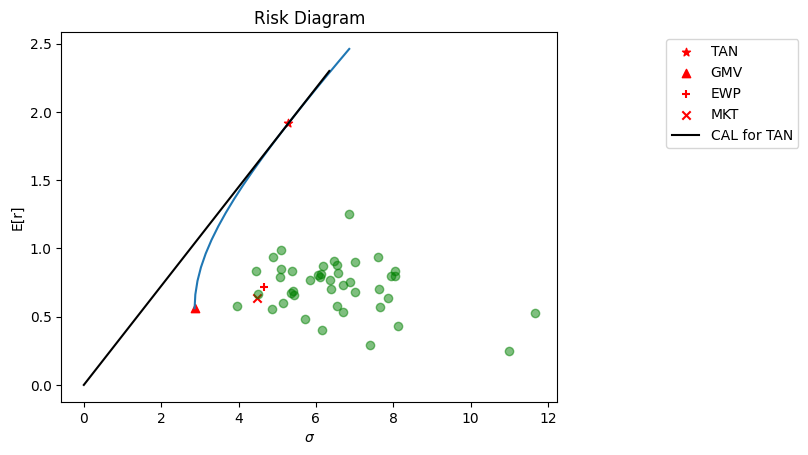

In [19]:
# Plot the efficient frontier along with the GMV and tangency portfolio
plt.plot(sigma_range, Er_range)

# tangency portfolio (TAN)
plt.scatter( evaluate_portfolio_performance (w_t, mu, V)['sigma'], evaluate_portfolio_performance (w_t, mu, V)['Er'], marker='*', color = 'red',label = 'TAN')

# global minimum variance portfolio (GMV)
plt.scatter( evaluate_portfolio_performance (w_g, mu, V)['sigma'], evaluate_portfolio_performance (w_g, mu, V)['Er'], marker='^', color = 'red',label = 'GMV')

# equally weighted portfolio (EWP)
w_e = np.array([1/43] * 43)
plt.scatter( evaluate_portfolio_performance (w_e, mu, V)['sigma'], evaluate_portfolio_performance (w_e, mu, V)['Er'], marker='+', color = 'red',label = 'EWP')

# Market Portfolio
plt.scatter(std_dev['Mkt-RF'], er['Mkt-RF'], marker = 'x', color = 'red', label = 'MKT')

# individual stocks
#plt.scatter(pd.DataFrame.from_dict(std_dev, orient='index').values, 
#            pd.DataFrame.from_dict(er, orient='index').values, 
#            marker = 'o', c = np.arange(52),
#            label = np.array(['MKT'] + industries + ['GMV', 'TAN', 'EWP']))
#CAL based on tangency portfolio
trange = np.arange(0,1.3,0.1)

plt.plot(trange * evaluate_portfolio_performance (w_t, mu, V)['sigma'] , (1- trange) * 0 + trange * evaluate_portfolio_performance (w_t, mu, V)['Er'], color = 'black',label = 'CAL for TAN')

# plot each of the 48 assets and MKT
for industry in (industries):
    plt.plot(std_dev[industry], er[industry], marker = 'o', color = 'green', alpha = 0.5)


plt.legend()
plt.title('Risk Diagram')
plt.xlabel('$\sigma$')
plt.ylabel('E[r]')
plt.legend(bbox_to_anchor = (1.5, 1))

plt.show()

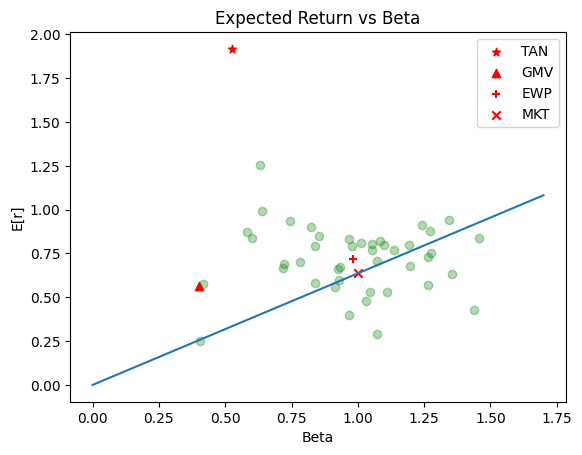

In [20]:
# tangency portfolio (TAN)
plt.scatter(beta['TAN'], evaluate_portfolio_performance (w_t, mu, V)['Er'], marker='*', color = 'red',label = 'TAN')

# global minimum variance portfolio (GMV)
plt.scatter(beta['GMV'], evaluate_portfolio_performance (w_g, mu, V)['Er'], marker='^', color = 'red',label = 'GMV')

# equally weighted portfolio (EWP)
plt.scatter(beta['EWP'], evaluate_portfolio_performance (w_e, mu, V)['Er'], marker='+', color = 'red',label = 'EWP')

# Market Portfolio
plt.scatter(beta['Mkt-RF'], er['Mkt-RF'], marker = 'x', color = 'red', label = 'MKT')

# plot each of the 48 assets
for industry in (industries):
    plt.plot(beta[industry], er[industry], marker = 'o', color = 'green', alpha = 0.3)


x = [0, 1.7]
y = [0, er['Mkt-RF'] * 1.7]
plt.plot(x,y)


plt.legend()
plt.title('Expected Return vs Beta')
plt.xlabel('Beta')
plt.ylabel('E[r]')

plt.show()

## Robust Estimation

In [21]:
# inserting month
excess_mkt.insert(loc = 0, column = 'Month', value = pd.to_datetime(data['Month'], format = '%Y%m'))

In [27]:
# splitting into training and test
data_train = excess_mkt[excess_mkt['Month'].dt.year < 2011].iloc[:, 1:]
data_test = excess_mkt[excess_mkt['Month'].dt.year >= 2011].iloc[:, 1:]

In [29]:
cov_matrix_train = data_train[industries].cov()
corr_matrix_train = data_train[industries].corr()

avg_excess_return_train = {}
std_excess_return_train = {}

for industry in industries:
    avg_excess_return_train[industry] = data_train[industry].mean()
    std_excess_return_train[industry] = data_train[industry].std()

In [33]:
# Assigning values to the expected return vector and the covariance matrix
mu_train = pd.DataFrame.from_dict(avg_excess_return, orient='index').values
V_train = cov_matrix_train.values

In [34]:
# getting gmv weights for train
w_g_train = gmv(V_train)
gmv_allocation_train = {}

for industry, w in zip(industries, w_g_train):
    gmv_allocation_train[industry] = w

In [35]:
# getting tangency weights for train
w_t_train = tangency(mu_train, V_train)
tangency_allocation_train = {}

for industry, w in zip(industries, w_t_train):
    tangency_allocation_train[industry] = w

In [38]:
gmv_weights = list(gmv_allocation_train.values())
tangency_weights = list(tangency_allocation_train.values())
ewp_weights = [1/43] * 43

data_train['GMV'] = data_train[industries].dot(gmv_weights)
data_train['TAN'] = data_train[industries].dot(tangency_weights)
data_train['EWP'] = data_train[industries].dot(ewp_weights)

cov_matrix_with_mkt = data_train.cov()
er_train = {}
std_dev_train = {}
sharpe_ratio_train = {}
beta_train = {}

for industry in data_train.columns:
    er_train[industry] = data_train[industry].mean()
    std_dev_train[industry] = data_train[industry].std()
    sharpe_ratio_train[industry] = er_train[industry]/std_dev_train[industry]
    beta_train[industry] = cov_matrix_with_mkt['MKT'][industry] / cov_matrix_with_mkt['MKT']['MKT']

In [39]:
performance_table_train = pd.DataFrame.from_dict([er_train, std_dev_train, sharpe_ratio_train, beta_train]).set_axis(['Expected Return', 'Standard Deviation', 'Sharpe Ratio', 'Beta'])
performance_table_train

,MKT,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals,GMV,TAN,EWP
Expected Return,0.561467,0.658833,0.740800,0.835933,0.928433,1.179633,0.464367,0.883933,0.357433,0.637400,...,0.654833,0.573433,0.766100,0.598033,0.447967,0.723033,0.699167,0.467903,1.688459,0.697483
Standard Deviation,4.657505,6.515449,4.666901,7.477219,5.443109,7.211306,6.962345,7.745372,5.854143,4.718053,...,7.229432,5.666205,6.315217,5.559001,5.079726,5.682582,5.374822,2.885562,5.534574,4.800862
Sharpe Ratio,0.120551,0.101119,0.158735,0.111797,0.170570,0.163581,0.066697,0.114124,0.061056,0.135098,...,0.090579,0.101202,0.121310,0.107579,0.088187,0.127237,0.130082,0.162153,0.305075,0.145283
Beta,1.000000,0.739905,0.596968,0.863437,0.662780,0.626891,1.034539,1.328024,1.014656,0.724253,...,1.289355,0.911906,0.948433,0.930458,0.909097,0.987182,0.852195,0.376723,0.520979,0.974127


In [58]:
# calculating beta shrink
beta = pd.DataFrame.from_dict([beta_train]).set_axis(['beta']).T
grand_mean = beta['beta'].mean()
beta['beta_shrink'] = beta['beta'] * 0.5 + 0.5 * grand_mean


In [68]:
# calculating returns using CAPM
expected_returns = pd.DataFrame.from_dict([er_train]).set_axis(['Er']).T
expected_returns['Er_CAPM'] = beta['beta_shrink'] * expected_returns['Er'] + er_train['MKT']

In [80]:
# calculating V_shrink
corr_matrix = data_train[industries].corr()
cov_matrix = data_train[industries].cov()

total = 0
for i in range(43):
    for j in range(i+1, 43):
        total += corr_matrix.iloc[i,j]

rho_bar = total / (43*42/2)
print('rho_bar: {:.6f}'.format(rho_bar))

V_CC = cov_matrix.copy(deep=True)
for i in range(43):
    for j in range(i+1, 43):
        V_CC.iloc[i,j] = cov_matrix.iloc[i,j] / corr_matrix.iloc[i,j] * rho_bar 
        V_CC.iloc[j,i] = cov_matrix.iloc[j,i] / corr_matrix.iloc[j,i] * rho_bar
        
V_shrink = 0.3*V_CC + 0.7*cov_matrix

rho_bar: 0.514777


In [87]:
# getting weights of TAN robust
mu_robust = np.array(expected_returns['Er_CAPM'][industries])
w_t_train_robust = tangency(mu_robust, V_shrink)

tangency_allocation_train_robust = {}

for industry, w in zip(industries, w_t_train_robust):
    tangency_allocation_train_robust[industry] = w

In [88]:
# getting weights of GMV robust
w_g_train_robust = gmv(V_shrink)
gmv_allocation_train_robust = {}

for industry, w in zip(industries, w_g_train_robust):
    gmv_allocation_train_robust[industry] = w

In [89]:
gmv_weights_robust = list(gmv_allocation_train_robust.values())
tangency_weights_robust = list(tangency_allocation_train_robust.values())

data_train['GMV_robust'] = data_train[industries].dot(gmv_weights_robust)
data_train['TAN_robust'] = data_train[industries].dot(tangency_weights_robust)

cov_matrix_with_mkt = data_train.cov()

for industry in ['GMV_robust', 'TAN_robust']:
    er_train[industry] = data_train[industry].mean()
    std_dev_train[industry] = data_train[industry].std()
    sharpe_ratio_train[industry] = er_train[industry]/std_dev_train[industry]
    beta_train[industry] = cov_matrix_with_mkt['MKT'][industry] / cov_matrix_with_mkt['MKT']['MKT']

In [90]:
performance_table_train = pd.DataFrame.from_dict([er_train, std_dev_train, sharpe_ratio_train, beta_train]).set_axis(['Expected Return', 'Standard Deviation', 'Sharpe Ratio', 'Beta'])
performance_table_train

,MKT,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Boxes,Trans,Whlsl,Rtail,Meals,GMV,TAN,EWP,GMV_robust,TAN_robust
Expected Return,0.561467,0.658833,0.740800,0.835933,0.928433,1.179633,0.464367,0.883933,0.357433,0.637400,...,0.766100,0.598033,0.447967,0.723033,0.699167,0.467903,1.688459,0.697483,0.486128,1.328098
Standard Deviation,4.657505,6.515449,4.666901,7.477219,5.443109,7.211306,6.962345,7.745372,5.854143,4.718053,...,6.315217,5.559001,5.079726,5.682582,5.374822,2.885562,5.534574,4.800862,3.055273,4.337998
Sharpe Ratio,0.120551,0.101119,0.158735,0.111797,0.170570,0.163581,0.066697,0.114124,0.061056,0.135098,...,0.121310,0.107579,0.088187,0.127237,0.130082,0.162153,0.305075,0.145283,0.159111,0.306155
Beta,1.000000,0.739905,0.596968,0.863437,0.662780,0.626891,1.034539,1.328024,1.014656,0.724253,...,0.948433,0.930458,0.909097,0.987182,0.852195,0.376723,0.520979,0.974127,0.418757,0.625886
